# Compare MLP and CNN models on FashionMNIST Classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import datasets, layers, Model, optimizers, regularizers, callbacks
from keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
!nvidia-smi

Thu Dec 11 16:49:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   40C    P0              9W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1- Data Preparation

### Load Dataset (FashinMNIST)

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
class_names = {0: 'T-shirt/top',
               1: 'Trouser',
               2: 'Pullover',
               3: 'Dress',
               4: 'Coat',
               5: 'Sandal',
               6: 'Shirt',
               7: 'Sneaker',
               8: 'Bag',
               9: 'Ankle boot'}

### Visualization

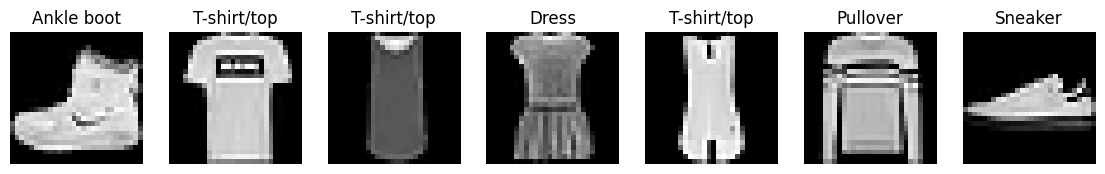

In [7]:
fig, axes = plt.subplots(1, 7, figsize=(14,10))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]])
    ax.set_axis_off()

### Pre-processing

In [10]:
# Normalization
X_train = train_images / 255.
X_test = test_images / 255.

In [9]:
X_train_mlp_ = X_train.reshape(-1, 28*28)
X_test_mlp = X_test.reshape(-1, 28*28)

In [11]:
X_train_cnn_ = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

In [11]:
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train_mlp_,
                                                                  train_labels,
                                                                  test_size=0.2,
                                                                  stratify=train_labels)
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn_,
                                                                  train_labels,
                                                                  test_size=0.2,
                                                                  stratify=train_labels)

In [12]:
train_distribution = np.bincount(y_train_mlp)
val_distribution = np.bincount(y_val_mlp)

In [13]:
train_distribution

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [14]:
val_distribution

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

## 2- Model Design

### MLP

In [29]:
inp = layers.Input(shape=(28*28,))
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(inp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(10, activation='softmax')(x)

model_mlp = Model(inputs=inp, outputs=out)
model_mlp.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

### CNN

In [5]:
inp = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(64, 3, padding='same')(inp)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.MaxPool2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.15)(x)
out = layers.Dense(10, activation='softmax')(x)

model_cnn = Model(inputs=inp, outputs=out)
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,490 (158.16 KB)

 Trainable params: 40,234 (157.16 KB)

 Non-trainable params: 256 (1.00 KB)

## 3- Training

In [30]:
model_mlp.compile(optimizer=optimizers.Adam(learning_rate=0.005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [64]:
model_cnn.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

### MLP

In [ ]:
history_mlp = model_mlp.fit(X_train_mlp, y_train_mlp,
                            epochs=50,
                            batch_size=256,
                            validation_data=(X_val_mlp, y_val_mlp))

### CNN

In [59]:
from datetime import datetime

now = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
now

'2025-12-11_18_29_36'

In [65]:
# Callbacks

checkpoint = callbacks.ModelCheckpoint(filepath=f'checkpoint_{now}.keras',
                                       monitor='val_loss',
                                       save_best_only=True)
logger = callbacks.CSVLogger(f'log_{now}.csv')
rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5,
                                    factor=0.1)

my_callbacks = [checkpoint, logger, rlrop]

In [66]:
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn,
                            epochs=50,
                            batch_size=256,
                            validation_data=(X_val_cnn, y_val_cnn),
                            callbacks=my_callbacks)

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5669 - loss: 1.3033 - val_accuracy: 0.1000 - val_loss: 3.3641 - learning_rate: 0.0010
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7276 - loss: 0.7936 - val_accuracy: 0.1824 - val_loss: 2.9697 - learning_rate: 0.0010
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7655 - loss: 0.6700 - val_accuracy: 0.5329 - val_loss: 1.2921 - learning_rate: 0.0010
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.7914 - loss: 0.5948 - val_accuracy: 0.6892 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8096 - loss: 0.5458 - val_accuracy: 0.6682 - val_loss: 1.0417 - learning_rate: 0.0010
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8217 - loss: 0.5099 - val_accuracy: 0.8117 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8312 - loss: 

## 4- Evaluation

### MLP

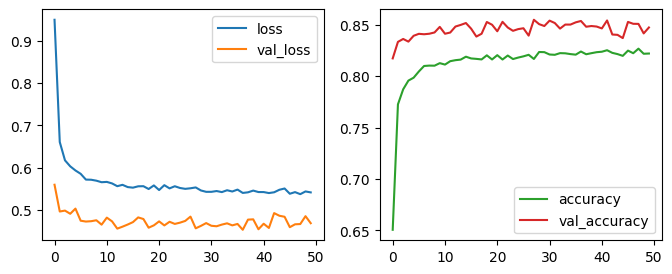

In [34]:
history_mlp_df = pd.DataFrame(history_mlp.history)
history_mlp_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [35]:
test_loss, test_acc = model_mlp.evaluate(X_test_mlp, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8433 - loss: 0.4908
Test accuracy: 84.33 %


In [21]:
preds_mlp = model_mlp.predict(X_test_mlp)
preds_mlp = np.argmax(preds_mlp, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
print(classification_report(test_labels, preds_mlp,
                            target_names=class_names.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.81      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.80      0.77      0.78      1000
       Dress       0.84      0.90      0.87      1000
        Coat       0.81      0.77      0.79      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.67      0.70      0.68      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.94      0.97      0.95      1000
  Ankle boot       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### CNN

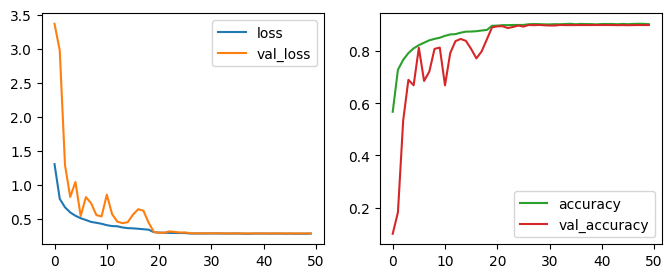

In [67]:
history_cnn_df = pd.DataFrame(history_cnn.history)
history_cnn_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [68]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8930 - loss: 0.3034
Test accuracy: 89.30 %


In [69]:
preds_cnn = model_cnn.predict(X_test_cnn)
preds_cnn = np.argmax(preds_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [70]:
print(classification_report(test_labels, preds_cnn,
                            target_names=class_names.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.84      0.84      0.84      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.83      0.81      0.82      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.71      0.70      0.70      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Load and evaluate checkpoints

In [7]:
# load model
from keras.saving import load_model

model_cnn_loaded = load_model('checkpoint_2025-12-11_18_29_36.keras')
model_cnn_loaded.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,960 (472.50 KB)

 Trainable params: 40,234 (157.16 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 80,470 (314.34 KB)

In [13]:
preds_cnn = model_cnn_loaded.predict(X_test_cnn)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [17]:
preds_cnn = np.argmax(preds_cnn, axis=1)

In [18]:
print(classification_report(test_labels, preds_cnn,
                            target_names=class_names.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.84      0.84      0.84      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.83      0.82      0.82      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.71      0.70      0.70      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



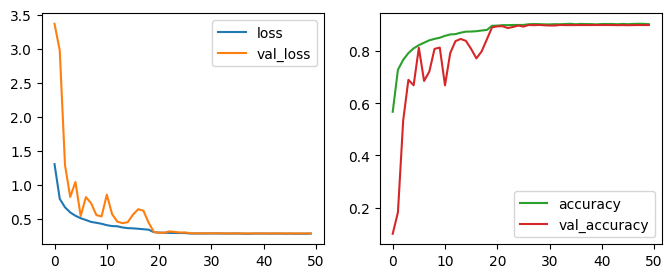

In [19]:
# Load history log
history_df_loaded = pd.read_csv('log_2025-12-11_18_29_36.csv')
history_df_loaded[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [21]:
history_df_loaded.columns

Index(['epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss'], dtype='object')